# MNISET
This notebook shows how to load the [MNISET](https://github.com/wouterkool/MNISET) dataset that was created as a side-effect of creating the [SET Finder](https://www.set-finder.com) app.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Load the data

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
DATASET_URL = 'https://github.com/wouterkool/MNISET/raw/master/data/MNISET.npz'

def load_mniset(datadir='data', dataset_url=DATASET_URL):
    os.makedirs(datadir, exist_ok=True)
    dataset_filename = os.path.join(datadir, os.path.split(dataset_url)[-1])
    if not os.path.isfile(dataset_filename):
        # download
        from urllib import request
        request.urlretrieve(dataset_url, dataset_filename)
    return np.load(dataset_filename)

def split_classes(y):
    # See plot_classes
    row, col = y // 9, y % 9
    qty, fill = row // 3, row % 3
    color, shape = col // 3, col % 3
    return qty, fill, color, shape

def make_labels(*args):
    return np.array(["-".join(feats) for feats in list(itertools.product(*args))])

def get_split(mniset, split='train'):
    if split == 'train':
        x, y = mniset['x_train'], mniset['y_train']
    elif split == 'test':
        x, y = mniset['x_test'], mniset['y_test']
    else:
        assert False, f"Unkown split {split}"
    return x, y

def create_classes(mniset, keep_feature_mask, defaults=[1, 2, 0, 2]):
    
    defaults = np.array(defaults) # 2 solid red squiggle
    
    num_orig_classes = 3 ** len(keep_feature_mask)
    # We can split the full classes into individual classes for features
    feat_classes = np.column_stack(split_classes(np.arange(num_orig_classes)))
    
    # Keep each original class if we want to keep it or it is the default for a feature
    keep_class_mask = ((feat_classes == defaults[None, :]) | keep_feature_mask[None, :]).all(-1)
    
    # Create feature labels for classes to keep and filter label imgs
    feature_names = mniset['feature_names'][keep_feature_mask]
    feature_labels = mniset['feature_labels'][keep_feature_mask]
    labels = make_labels(*feature_labels)
    label_imgs = mniset['label_imgs'][keep_class_mask]
    return labels, label_imgs, feature_names, feature_labels

def combine_classes(y_feat):
    # Convert 'base 3' representation to single decimal
    return ((3 ** np.arange(y_feat.shape[-1])[::-1])[None, :] * y_feat).sum(-1)

def extract_dataset(mniset, split='train', qty=True, fill=True, color=True, shape=True):
    
    keep_feature_mask = np.array([qty, fill, color, shape])
    assert keep_feature_mask.any(), "Need to have at least one feature in class"
    
    x, y = get_split(mniset, split)
    
    labels, label_imgs, feature_names, feature_labels = create_classes(
        mniset, keep_feature_mask
    )
    
    # Get individual features based on labels and keep only those which we want to keep
    y_feat = np.column_stack(split_classes(y))[:, keep_feature_mask]
    # Combine the classes for the features
    y = combine_classes(y_feat)
    
    # Convert to float 0-1
    return x / 255., y, labels, label_imgs / 255.

def extract_grayscale_dataset(mniset, split='train', qty=True, fill=True, color=False, shape=True):
    # Converts images to grayscale and has color feature disabled by default
    x, y, labels, label_imgs = extract_dataset(
        mniset, split, qty, fill, color, shape
    )
    # Convert to grayscale
    x, label_imgs = x.mean(-1), label_imgs.mean(-1)
    return x, y, labels, label_imgs

In [3]:
mniset = load_mniset()
x_train, y_train, labels, label_imgs = extract_dataset(mniset, split='train')
x_test, y_test, *_ = extract_dataset(mniset, split='test')

print(len(x_train), " train images, ", len(x_test), "test images")
print("x_train.shape", x_train.shape)
print("x_train range", [x_train.min(), x_train.max()])
print("y_train.shape", y_train.shape)

3036  train images,  922 test images
x_train.shape (3036, 28, 28, 3)
x_train range [0.0, 1.0]
y_train.shape (3036,)


## Plot random sample

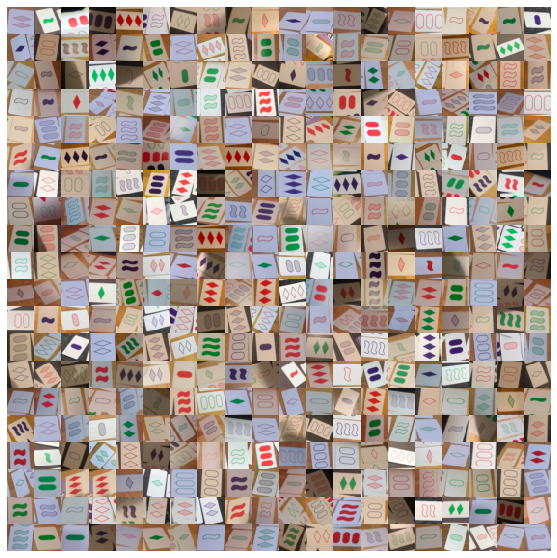

In [4]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def tile(imgs, n=20):
    return np.vstack([np.hstack(img_chunk) for img_chunk in chunks(imgs, n)])

def plot_sample(x):
    nrows = int(np.sqrt(len(x)) + 0.5)
    ncols = len(x) // nrows + (1 if len(x) % nrows != 0 else 0)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(tile(x, ncols), cmap='gray' if x.ndim == 3 else None)
    plt.axis('off')
    plt.show()
    
sample_idx = np.random.choice(len(x_train), 400)
plot_sample(x_train[sample_idx])

## Plot frequencies of classes

Train , num classes 81 , min freq. 20 , max freq. 57 , avg freq. 37.48148148148148


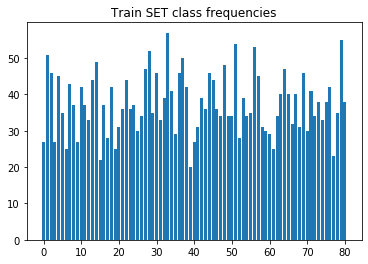

Test , num classes 81 , min freq. 2 , max freq. 23 , avg freq. 11.382716049382717


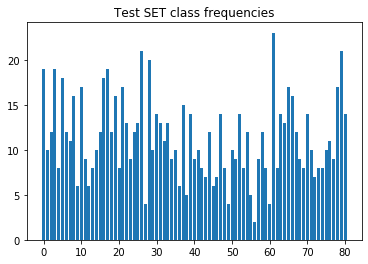

In [5]:
def plot_frequencies(y, num_classes=None, title='MNISET'):
    
    freq = np.bincount(y)
    if num_classes is None:
        num_classes = len(freq)
    else:
        assert len(freq) == num_classes
    assert (freq > 0).all()
    print(title.title(),
          ", num classes", num_classes, 
          ", min freq.", freq.min(), 
          ", max freq.", freq.max(), 
          ", avg freq.", freq.mean())
    plt.bar(np.arange(num_classes), freq)
    plt.title("{} SET class frequencies".format(title.title()))
    plt.show()

plot_frequencies(y_train, len(labels), title='Train')
plot_frequencies(y_test, len(labels), title='Test')

## Plot class 'label images'
The dataset comes with a clean example 'label image' for each class, as well as a string label.

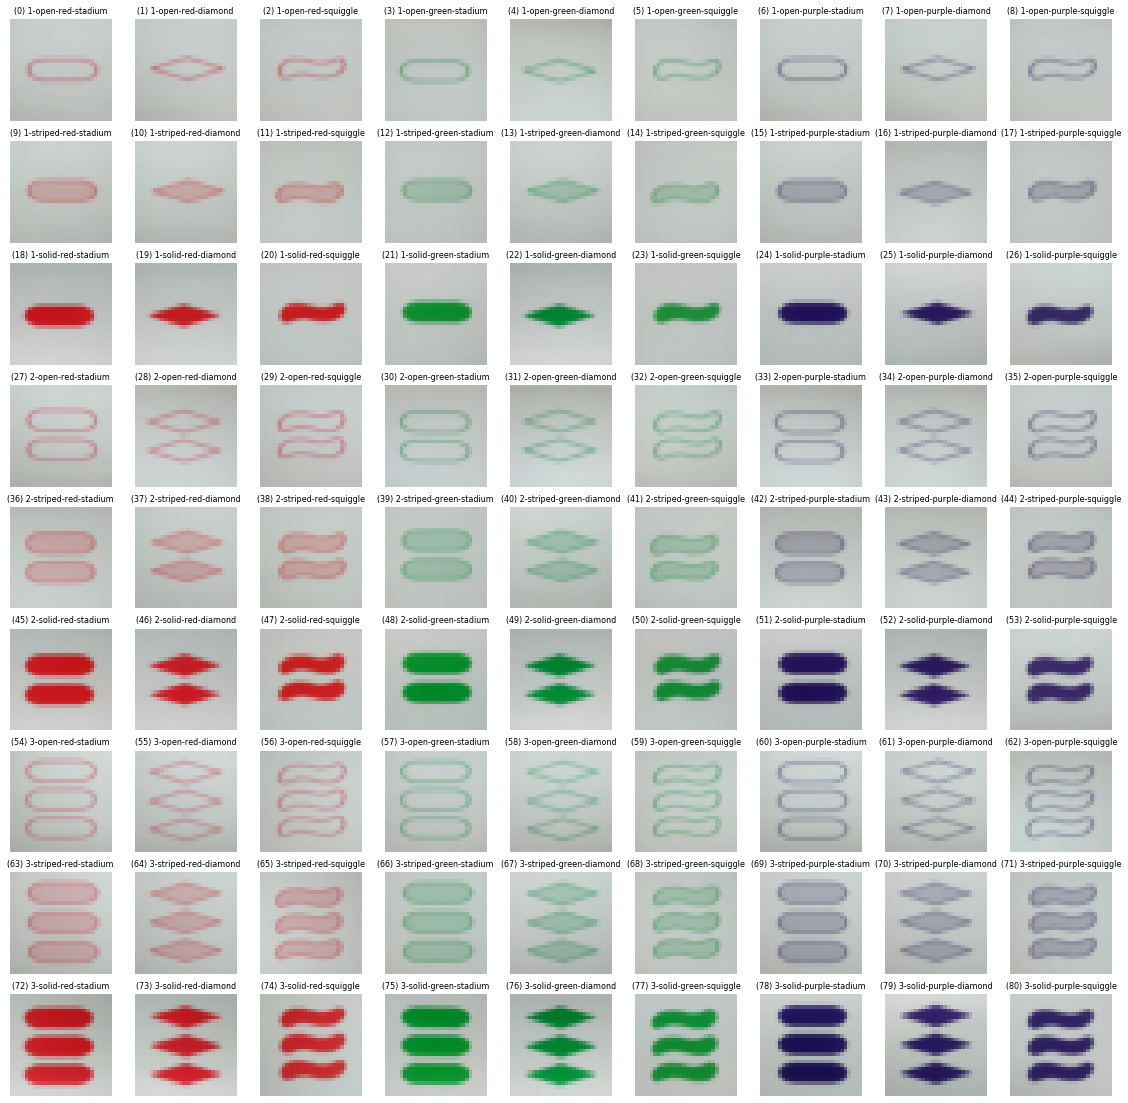

In [6]:
def plot_classes(label_imgs, labels, title=None):
    num_classes = len(labels)
    cols = 9 if num_classes > 9 else 3
    rows = num_classes // cols
    assert num_classes % cols == 0
    fig, axarr = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    for i, (label_img, label) in enumerate(zip(label_imgs, labels)):
        row, col = i // cols, i % cols
        ax = axarr[row, col] if rows > 1 else axarr[col]
        ax.imshow(label_img, cmap='gray' if label_img.ndim == 2 else None)
        ax.set_title(f'({i}) {label}', fontsize=8)
        ax.axis('off')
    if title is not None:
        plt.suptitle(title, y=1.02)
    plt.show()

plot_classes(label_imgs, labels)

## Grayscale MNISET
We can make a grayscale MNISET dataset just like the original MNIST dataset, using `extract_grayscale_dataset`. By default, this will also remove the color feature from the classes for a classification problem with 27 classes. To address the full 81 class problem with the grayscale dataset, add `color=True` (not recommended).

Train (Grayscale) , num classes 27 , min freq. 79 , max freq. 150 , avg freq. 112.44444444444444


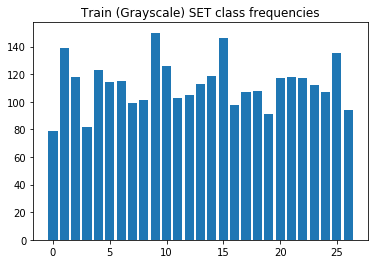

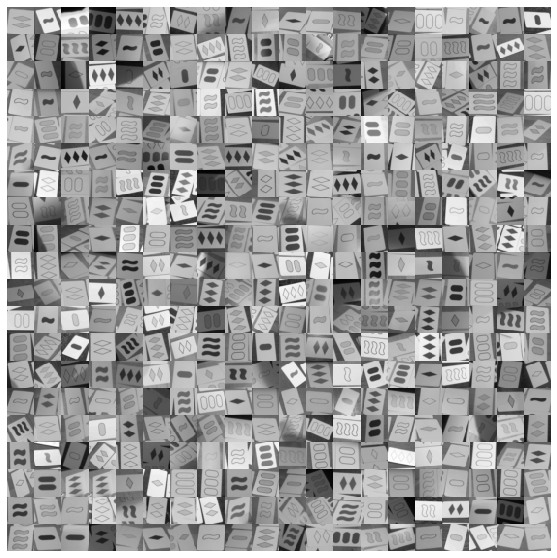

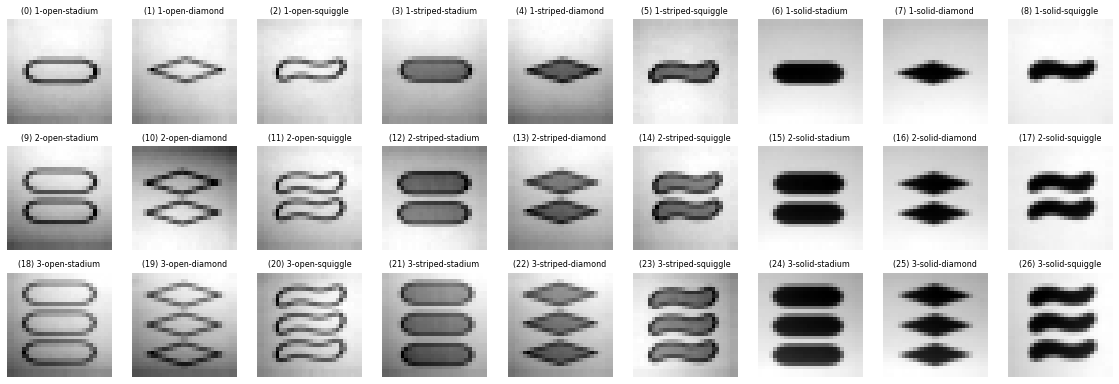

In [7]:
x_train_gray, y_train_gray, labels_gray, label_imgs_gray = extract_grayscale_dataset(mniset)

# x_test_gray, y_test_gray, *_ = extract_grayscale_dataset(mniset, split='test')

plot_frequencies(y_train_gray, len(labels_gray), title='Train (grayscale)')

plot_sample(x_train_gray[sample_idx])

plot_classes(label_imgs_gray, labels_gray)

## Simplified datasets
Just like we (by default) removed the color feature from the classes when using the grayscale dataset, we can remove other features to simplify the classification problem, by using `qty=False`, `fill=False`, `color=False` or `shape=False`.

Train (Simple) , num classes 9 , min freq. 276 , max freq. 401 , avg freq. 337.3333333333333


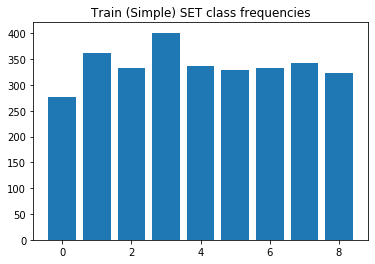

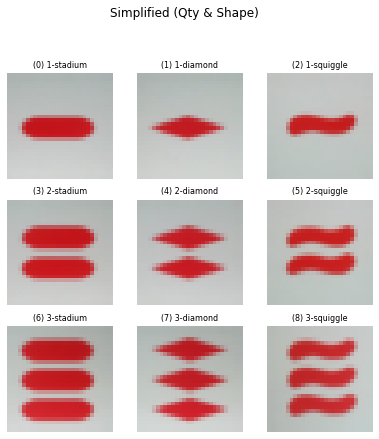

In [8]:
# Only use 9 classes based on qty and shape by disabling fill and color
x_train_simple, y_train_simple, labels_simple, label_imgs_simple = \
    extract_dataset(mniset, fill=False, color=False)

# Note that this does not affect the imput data, only the labels!
assert (x_train_simple == x_train).all()

plot_frequencies(y_train_simple, len(labels_simple), title='Train (simple)')

# For the 'label images', the other features will have default values (e.g. solid red)!
plot_classes(label_imgs_simple, labels_simple, title='Simplified (Qty & Shape)')

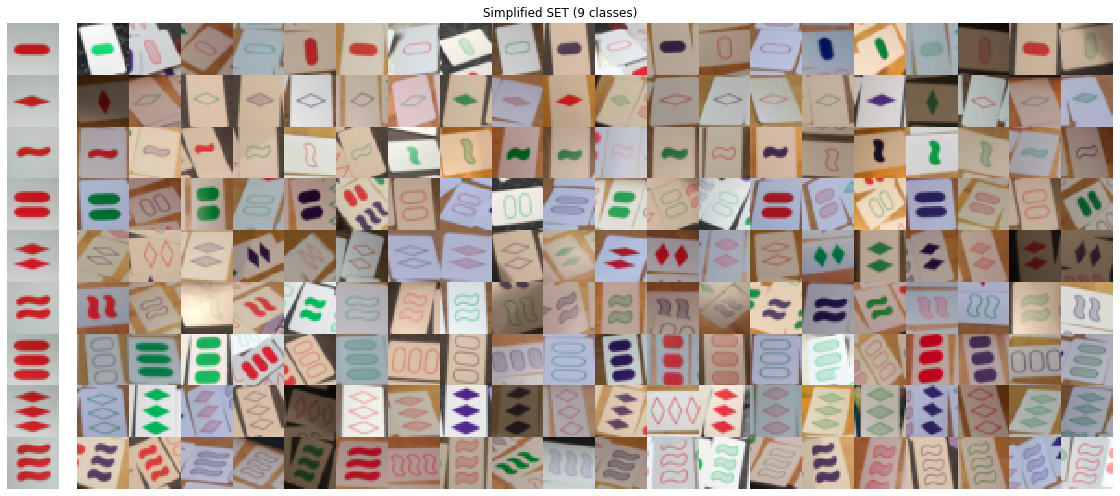

In [10]:
def plot_per_class(x, y, label_imgs, max_per_class=20, title=''):
    rows = []
    max_per_class = min(max_per_class, np.bincount(y).max())
    for i, label_img in enumerate(label_imgs):
        idx = np.where(y == i)[0]
        idx = np.random.choice(idx, min(max_per_class, len(idx)), replace=False)
        x_i = x[idx]
        x_i = np.pad(x_i, ((0, max_per_class - len(x_i)),) + ((0, 0),) * (x.ndim - 1), mode='constant', constant_values=1)
        rows.append(np.hstack((label_img, np.ones_like(label_img[:, :10]), *x_i)))

    fig, ax = plt.subplots(figsize=(20, 20 / (max_per_class + 1) * len(label_imgs)))
    imggrid = np.vstack(rows)
    ax.imshow(imggrid, cmap='gray' if imggrid.ndim == 2 else None)
    plt.axis('off')
    plt.title(f"{title} ({len(label_imgs)} classes)")
    plt.show()
    
plot_per_class(x_train, y_train_simple, label_imgs_simple, title='Simplified SET')

## Plot full dataset

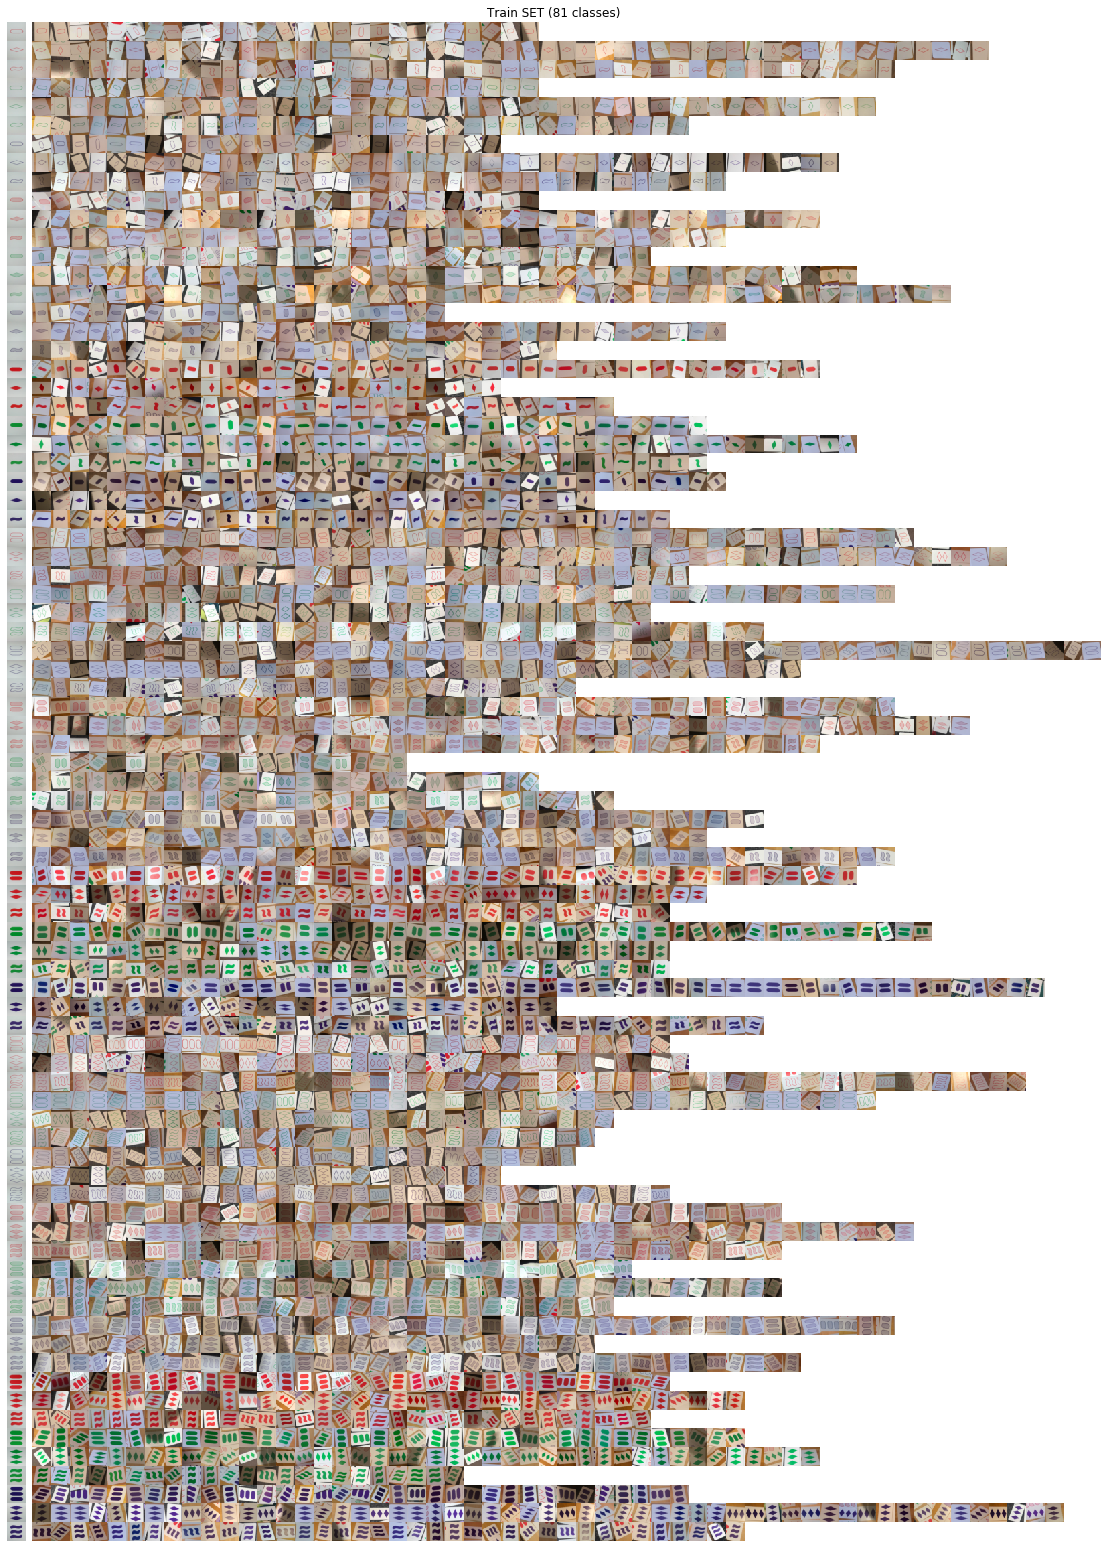

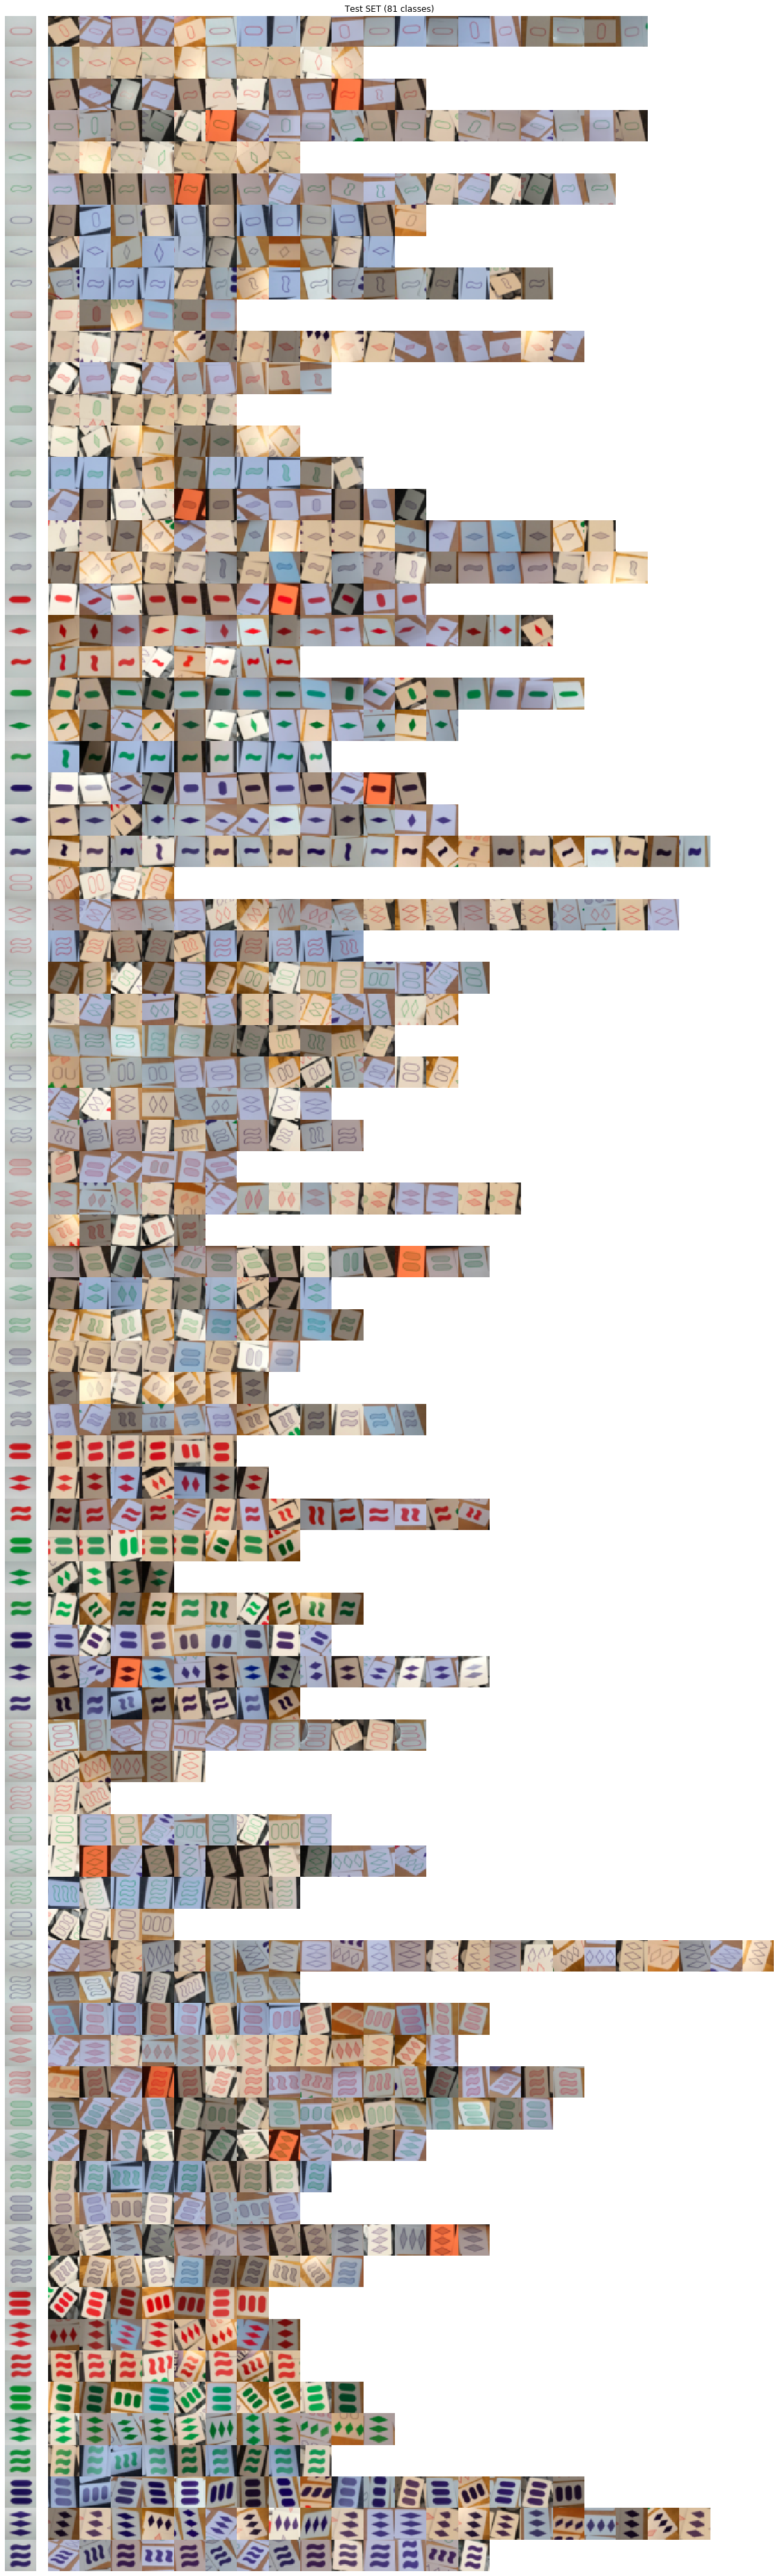

In [11]:
plot_per_class(x_train, y_train, label_imgs, max_per_class=100, title='Train SET')
plot_per_class(x_test, y_test, label_imgs, max_per_class=100, title='Test SET')